In [1]:
from time import perf_counter
import os
from joblib import Parallel, delayed
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()

np.random.seed(SEED)

In [2]:
def run_experiment(g, Exps, graph_p, signal_p, def_args, verb):
    Adj_list = utils.create_dinamic_graph(**graph_p)
    X_list, X0 = utils.create_dinamic_gmrf_signals(Adj_list, **signal_p)

    n_nodes = Adj_list[-1].shape[0]
    n_samples = np.array( [X_i.shape[1] for X_i in X_list] ).sum()

    # n_iters = np.array( [X_i.shape[1] for X_i in X_list] ).sum()
    # n_iters *= def_args['iters_sample'] if 'iters_sample' in def_args.keys() else 1
    # n_iters += len(X_list)
    n_iters = n_samples #+ len(X_list)

    err_graphs = np.zeros((len(Adj_list), len(Exps)))
    err_seq = np.zeros((n_iters, len(Exps)))
    err_first = np.zeros_like(err_graphs)
    runtime = np.zeros(len(Exps))
    for i, exp in enumerate(Exps):
        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        args_aux['lamb'] = utils.lamb_value(n_nodes, n_samples, args_aux['lamb'])
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, X_init=X0, **args_aux)
        t_end = perf_counter()

        err_graphs[:,i] = model.test_err(Adj_list)
        err_seq[:,i] = model.test_sequence_err(Adj_list)
        err_first[:,i] = model.test_err_graph_i(Adj_list, 0)
        runtime[i] = t_end - t_init

        if verb and g % N_CPUS == 0:
            print(f'- {g+1}. {exp["leg"]}: Err 1st graph: {err_graphs[0,i]:.3f}   -   Err last graph: {err_graphs[-1,i]:.3f}   ' +\
                  f'-   time: {runtime[i]:.3f} secs')            

    return err_graphs, err_seq, err_first, runtime

def plot_results(exps, err_graphs, err_seq, err_first, graph_p, agg='mean'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Compute growing number of nodes
    graph_dims = np.ones(len(graph_p['new_nodes']) + 1) * graph_p['n_nodes']
    for i, new_nodes in enumerate(graph_p['new_nodes']):
        graph_dims[i+1] = graph_dims[i] + new_nodes

    utils.plot_data(axes[0], err_graphs, exps, graph_dims, 'Number of nodes', 'Error growing graph',
                    agg=agg, deviation='prctile')
    utils.plot_data(axes[1], err_first, exps, graph_dims, 'Number of nodes', 'Error 1st block',
                    agg=agg, deviation='prctile')
    utils.plot_data(axes[2], err_seq, exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq',
                    deviation='prctile')
    plt.tight_layout()


# Low variance regime

In [3]:
n_graphs = 25
N = 50
verb = True
graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_nodes': [5]*2,
    'new_edges': 4,
    'load_adjs_fact': .1, #.01,
    'conn_nodes': True,
}

## Signal parameters
signal_p = {
    'samples_t': 500, #[250, 250, 250],
    'noise_power': .05,
    'init_samples': 500,
}

## Online model

CPUs employed: 64


- 1. 3: Err 1st graph: 0.104   -   Err last graph: 0.095   -   time: 0.674 secs
- 1. 3: Err 1st graph: 0.107   -   Err last graph: 0.099   -   time: 0.690 secs
- 1. 3: Err 1st graph: 0.112   -   Err last graph: 0.105   -   time: 0.680 secs
- 1. 3: Err 1st graph: 0.122   -   Err last graph: 0.120   -   time: 0.681 secs
----- Solved in 0.058 minutes -----


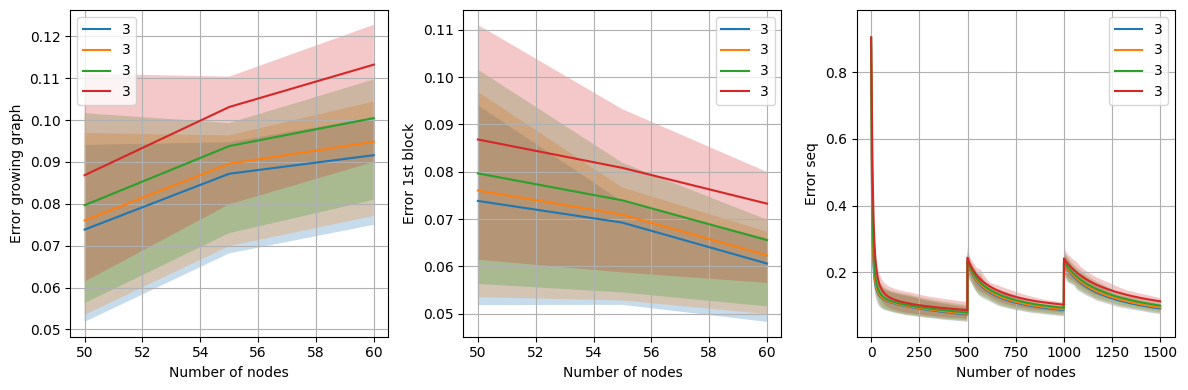

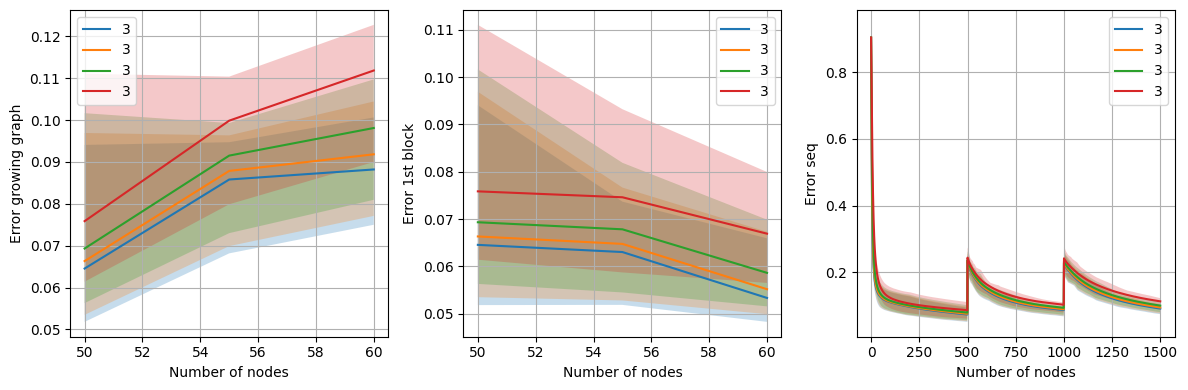

In [4]:
# Default args
default_args = {
    'iters_sample': 50,
    'lamb': .5,  # 1e-2,
    'stepsize': 5e-3,  # 1e-3
    'gamma': .99, 
    'epsilon': 1,
    'alpha': 0,
    'cold_start': False,
}

Exps = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr', 'opt': 'pgd'}, 'args': {'alpha': 0,},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr', 'opt': 'pgd', 'h': .9}, 'args': {'alpha': 0,},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr', 'opt': 'pgd', 'h': .75}, 'args': {'alpha': 0,},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr', 'opt': 'pgd', 'h': .5}, 'args': {'alpha': 0,},
     'leg': '3', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
err_graphs, err_seq, err_first, runtime = zip(*results)
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

plot_results(Exps, err_graphs, err_seq, err_first, graph_p)
plot_results(Exps, err_graphs, err_seq, err_first, graph_p, agg='median')

CPUs employed: 64
- 1. 3: Err 1st graph: 0.443   -   Err last graph: 0.418   -   time: 12.100 secs
- 1. 3: Err 1st graph: 0.422   -   Err last graph: 0.399   -   time: 11.931 secs
- 1. 3: Err 1st graph: 0.390   -   Err last graph: 0.369   -   time: 11.963 secs
- 1. 3: Err 1st graph: 0.327   -   Err last graph: 0.308   -   time: 12.037 secs
- 1. 3: Err 1st graph: 0.253   -   Err last graph: 0.240   -   time: 12.036 secs
- 1. 3: Err 1st graph: 0.210   -   Err last graph: 0.166   -   time: 0.639 secs
----- Solved in 1.018 minutes -----


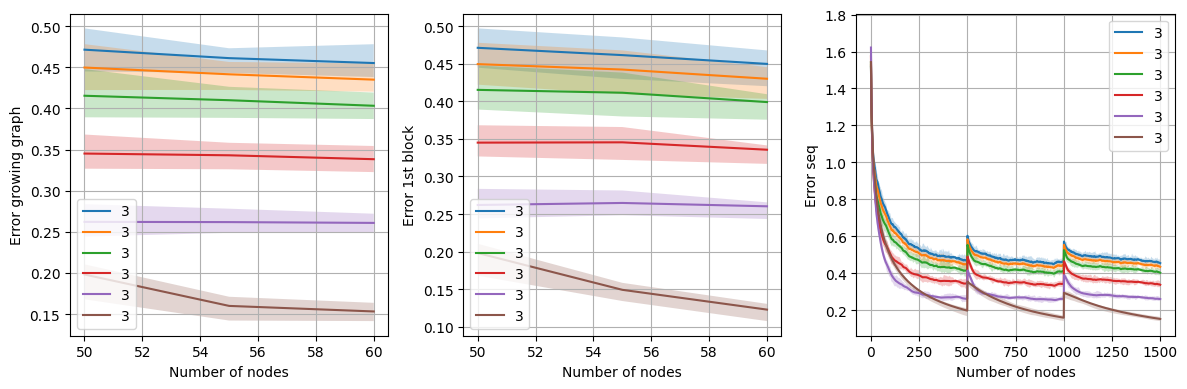

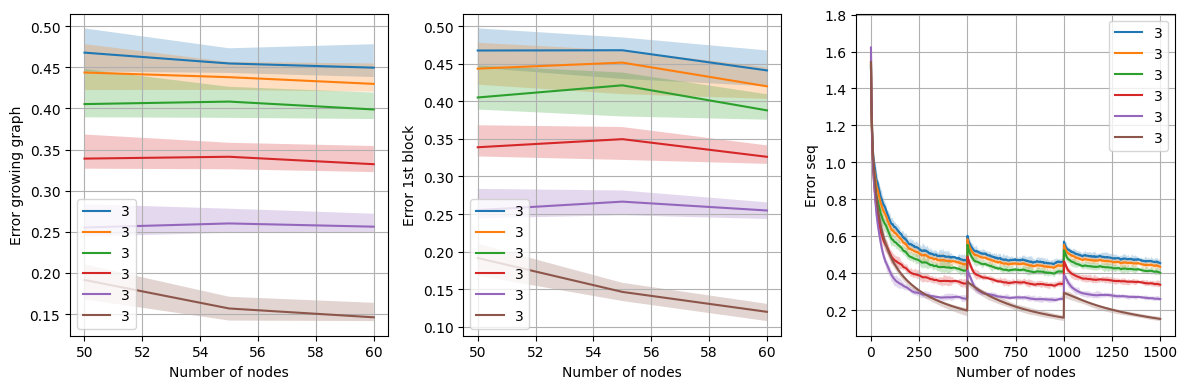

In [5]:
# Default args
default_args = {
    'iters_sample': 20,
    'lamb': .5,  # 1e-2,
    'stepsize': 5e-3,  # 1e-3
    'gamma': .95, 
    'epsilon': .5,
    'alpha': 0,
    'cold_start': False,
}

Exps = [
    # {'model': models.Online_dyn_nti, 'args': {'stepsize': 5e-4,}, 'leg': '1', 'fmt': '-'},    
    # {'model': models.Online_dyn_nti, 'args': {'stepsize': 1e-3,}, 'leg': '1', 'fmt': '-'},    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'stepsize': 5e-3, 'gamma': .6},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'stepsize': 5e-3, 'gamma': .7},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'stepsize': 5e-3, 'gamma': .8},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'stepsize': 5e-3, 'gamma': .9},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'stepsize': 5e-3, 'gamma': .95},
     'leg': '3', 'fmt': '-'},
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'stepsize': 5e-3,
    #  'iters_sample': 1}, 'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'stationary'}, 'args': {'stepsize': 5e-3,
     'iters_sample': 1}, 'leg': '3', 'fmt': '-'},
    # {'model': models.Online_dyn_nti, 'args': {'stepsize': 1e-2,}, 'leg': '4', 'fmt': '-'},    
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
err_graphs, err_seq, err_first, runtime = zip(*results)
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

plot_results(Exps, err_graphs, err_seq, err_first, graph_p)
plot_results(Exps, err_graphs, err_seq, err_first, graph_p, agg='median')

## Offline model

CPUs employed: 64
- 1. 5: Err 1st graph: 0.068   -   Err last graph: 0.065   -   time: 5.953 secs
----- Solved in 0.107 minutes -----


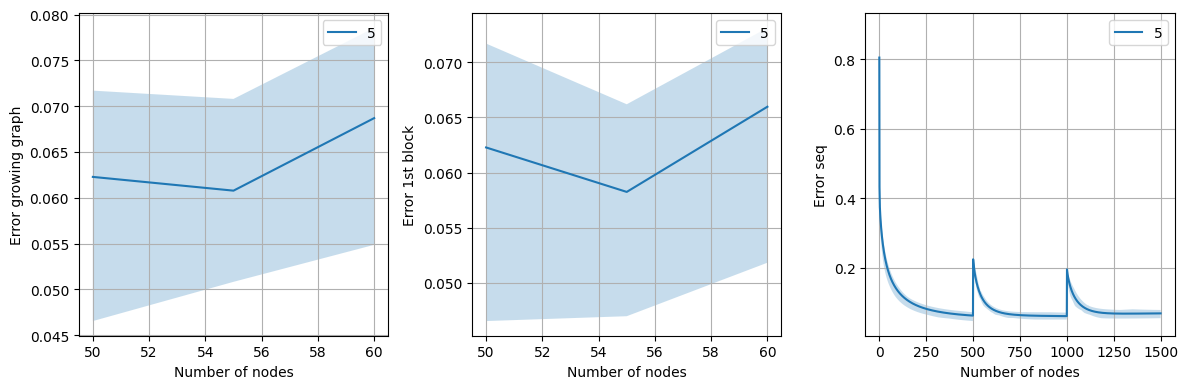

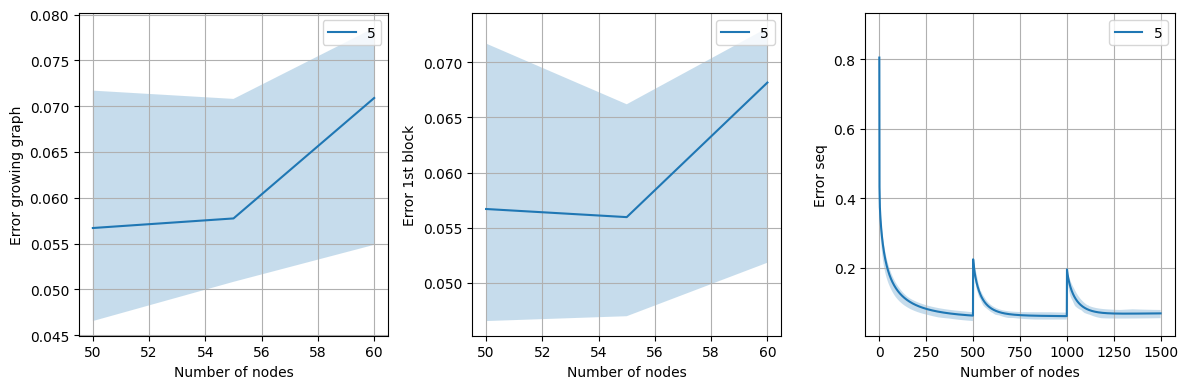

In [5]:
# Default args
default_args = {
    'iters_sample': 10,
    'lamb': .5,  # 1e-2,
    'stepsize': 5e-3,
    'gamma': .95, 
    'epsilon': .5,
    'alpha': 0,
}  

Exps = [
    {'model': models.Offline_dyn_nti, 'args': {'lamb': .5,}, 'leg': '5', 'fmt': '-'},    
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_graphs, err_seq, err_first, runtime = zip(*results)

plot_results(Exps, err_graphs, err_seq, err_first, graph_p)
plot_results(Exps, err_graphs, err_seq, err_first, graph_p, agg='median')

# High Variance Regime

In [5]:
n_graphs = 25
N = 50
graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_nodes': [2]*30,
    'new_edges': 4,
    'load_adjs_fact': .01, #.01,
    'conn_nodes': True,
}

## Signal parameters
signal_p = {
    'samples_t': [500] + [100]*5,
    'noise_power': .05,
}

CPUs employed: 64
- 1. 3: Err 1st graph: 0.296   -   Err last graph: 0.325   -   time: 1.503 secs
- 1. 3: Err 1st graph: 0.296   -   Err last graph: 0.289   -   time: 1.511 secs
- 1. 3: Err 1st graph: 0.136   -   Err last graph: 0.719   -   time: 69.466 secs
- 1. 3: Err 1st graph: 0.136   -   Err last graph: 1.313   -   time: 69.288 secs
----- Solved in 2.386 minutes -----


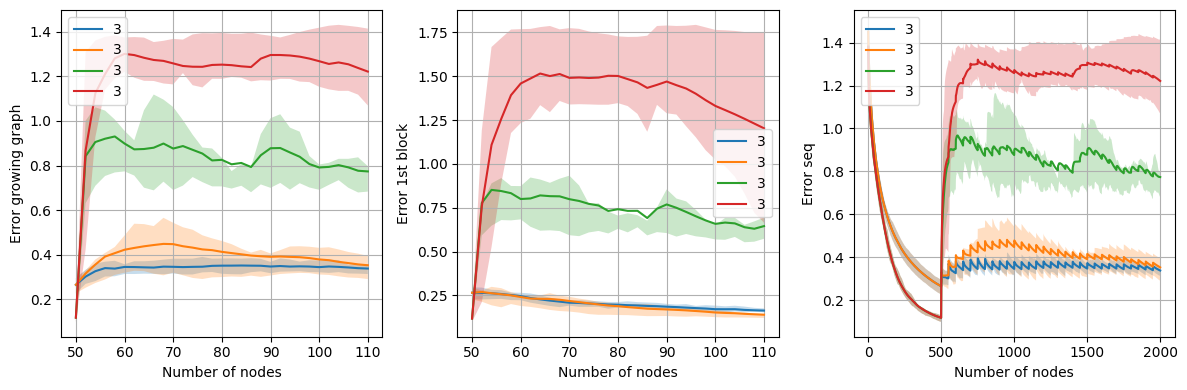

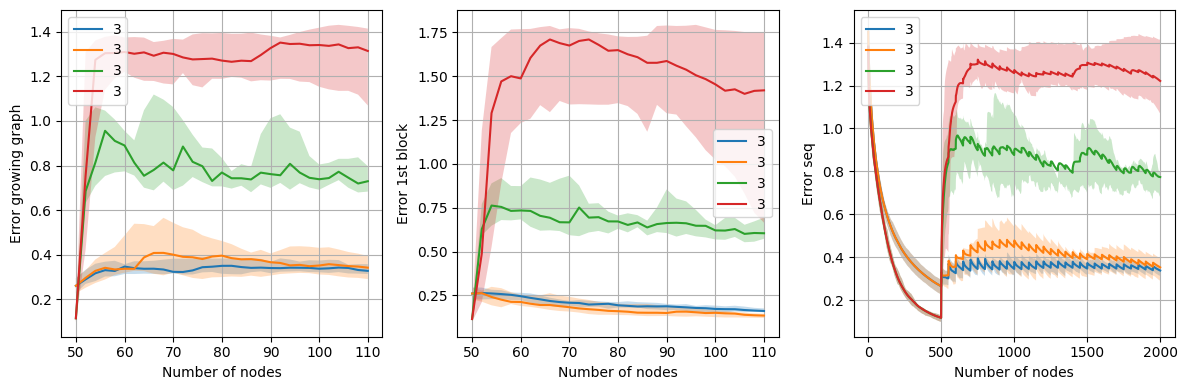

In [6]:
# Default args
default_args = {
    'iters_sample': 1,
    'lamb': .5,  # 1e-2,
    'stepsize': 5e-3,  # 1e-3
    'gamma': .99, 
    'epsilon': .5,
    'alpha': 0,
    'cold_start': False,
}

Exps = [

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'args': {'stepsize': 5e-3, 'gamma': .95, 'iters_sample': 1},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'args': {'stepsize': 5e-3, 'gamma': .99, 'iters_sample': 1},
     'leg': '3', 'fmt': '-'},
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'args': {'stepsize': 5e-3, 'gamma': .95, 'iters_sample': 50},
     'leg': '3', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'args': {'stepsize': 5e-3, 'gamma': .99, 'iters_sample': 50},
     'leg': '3', 'fmt': '-'},


    # {'model': models.Online_dyn_nti, 'args': {'stepsize': 1e-2,}, 'leg': '4', 'fmt': '-'},    
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
err_graphs, err_seq, err_first, runtime = zip(*results)
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

plot_results(Exps, err_graphs, err_seq, err_first, graph_p)
plot_results(Exps, err_graphs, err_seq, err_first, graph_p, agg='median')